In [ ]:
# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from qick import *

# for now, all the tProc v2 classes need to be individually imported (can't use qick.*)

# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSpan, QickSweep1D

# crank up the logging (optional)
import logging
# logging.basicConfig(level=logging.DEBUG)
logging.basicConfig(level=logging.INFO, force=True, format='%(levelname)-8s [%(filename)s:%(lineno)d] %(message)s')

# use pyro's traceback code instead of ipython's (optional)
# adapted from https://pyro4.readthedocs.io/en/stable/errors.html and https://stackoverflow.com/a/70433500
import IPython
import Pyro4.util
import sys

from IPython import get_ipython
ip = get_ipython()

def exception_handler(self, etype, evalue, tb, tb_offset=None):
    sys.stderr.write("".join(Pyro4.util.getPyroTraceback()))
    # self.showtraceback((etype, evalue, tb), tb_offset=tb_offset)  # standard IPython's printout

ip.set_custom_exc((Exception,), exception_handler)  # register your handler

from qick.pyro import make_proxy
soc, soccfg = make_proxy(ns_host="192.168.137.8", ns_port=8884, proxy_name="charles_qick")
print(soccfg)

In [5]:
# ZCU216, full-speed gen
GEN_CH = 0
RO_CH = 0
TRIG_TIME = 0.40
FREQ = 500

In [6]:
# making a random program
class TestProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['freq'], gen_ch=gen_ch)

        ramp_len = 0.2
        self.add_gauss(ch=gen_ch, name="ramp", sigma=ramp_len/10, length=ramp_len, even_length=True)
        
        self.add_pulse(ch=gen_ch, name="myflattop", ro_ch=ro_ch, 
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       length=0.1,
                       phase=0,
                       gain=1.0, 
                      )

        self.add_pulse(ch=gen_ch, name="mygaus", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0, 
                      )

    def _body(self, cfg):
            self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)
    
            self.pulse(ch=cfg['gen_ch'], name="myflattop", t=0)
            self.pulse(ch=cfg['gen_ch'], name="mygaus", t=0.4)

config = {'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': FREQ,
          'trig_time': TRIG_TIME,
          'ro_len': 1,
         }

prog = TestProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=10)
t = prog.get_time_axis(ro_index=0)

plt.plot(t, iq_list[0][:,0], label="I value")
plt.plot(t, iq_list[0][:,1], label="Q value")
plt.plot(t, np.abs(iq_list[0].dot([1,1j])), label="magnitude")
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us");

Traceback (most recent call last):
  File "C:\Users\csnipp\Documents\charles_qick\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\csnipp\AppData\Local\Temp\13\ipykernel_7012\1459960516.py", line 43, in <module>
    prog = TestProgram(soccfg, reps=1, final_delay=0.5, cfg=config)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\csnipp\Documents\charles_qick\Lib\site-packages\qick\asm_v2.py", line 2406, in __init__
    self.compile()
  File "C:\Users\csnipp\Documents\charles_qick\Lib\site-packages\qick\asm_v2.py", line 2423, in compile
    self.make_program()
  File "C:\Users\csnipp\Documents\charles_qick\Lib\site-packages\qick\asm_v2.py", line 2493, in make_program
    self._initialize(self.cfg)
  File "C:\Users\csnipp\AppData\Local\Temp\13\ipykernel_7012\1459960516.py", line 8, in _initialize
    self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=

  0%|          | 0/10 [00:00<?, ?it/s]

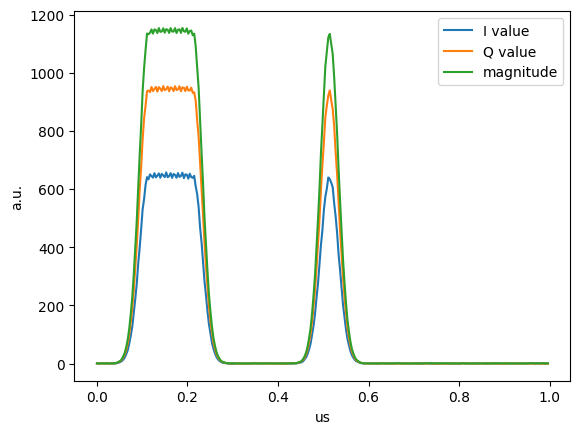

In [35]:
# do the same thing but at a different frequency
# making a random program
class TestProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['freq'], gen_ch=gen_ch)

        ramp_len = 0.2
        self.add_gauss(ch=gen_ch, name="ramp", sigma=ramp_len/10, length=ramp_len, even_length=True)
        
        self.add_pulse(ch=gen_ch, name="myflattop", ro_ch=ro_ch, 
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       length=0.1,
                       phase=0,
                       gain=1.0, 
                      )

        self.add_pulse(ch=gen_ch, name="mygaus", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0, 
                      )

    def _body(self, cfg):
            self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)
    
            self.pulse(ch=cfg['gen_ch'], name="myflattop", t=0)
            self.pulse(ch=cfg['gen_ch'], name="mygaus", t=0.4)

config = {'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': FREQ / 2, # 250
          'trig_time': TRIG_TIME,
          'ro_len': 1,
         }

prog = TestProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=10)
t = prog.get_time_axis(ro_index=0)

plt.plot(t, iq_list[0][:,0], label="I value")
plt.plot(t, iq_list[0][:,1], label="Q value")
plt.plot(t, np.abs(iq_list[0].dot([1,1j])), label="magnitude")
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us");
# not immediately obvious to me why the amplitude changes with frequency

  0%|          | 0/10 [00:00<?, ?it/s]

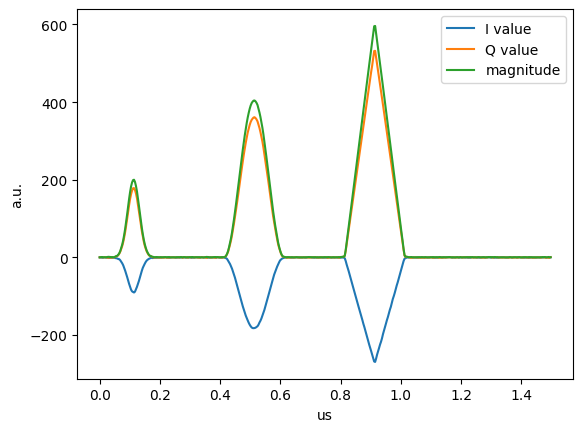

In [5]:
# testing out different envelopes
class TestProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['freq'], gen_ch=gen_ch)

        ramp_len = 0.2
        self.add_gauss(ch=gen_ch, name="ramp", sigma=ramp_len/10, length=ramp_len, even_length=True)

        cos_len = 0.2
        self.add_cosine(ch=gen_ch, name="cos", length=cos_len, even_length=True)

        tri_len = 0.2
        self.add_triangle(ch=gen_ch, name="tri", length=tri_len, even_length=True)

        self.add_pulse(ch=gen_ch, name="mygaus", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=0.2, 
                      )

        self.add_pulse(ch=gen_ch, name="mycos", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="cos", 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=0.4, 
                      )

        self.add_pulse(ch=gen_ch, name="mytri", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="tri", 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=0.6, 
                      )

    def _body(self, cfg):
            self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)
            self.pulse(ch=cfg['gen_ch'], name="mygaus", t=0)
            self.pulse(ch=cfg['gen_ch'], name="mycos", t=0.4)
            self.pulse(ch=cfg['gen_ch'], name="mytri", t=0.8)
            

config = {'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': FREQ,
          'trig_time': TRIG_TIME,
          'ro_len': 1.5,
         }

prog = TestProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=10)
t = prog.get_time_axis(ro_index=0)

plt.plot(t, iq_list[0][:,0], label="I value")
plt.plot(t, iq_list[0][:,1], label="Q value")
plt.plot(t, np.abs(iq_list[0].dot([1,1j])), label="magnitude")
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us")

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 0, 'us')

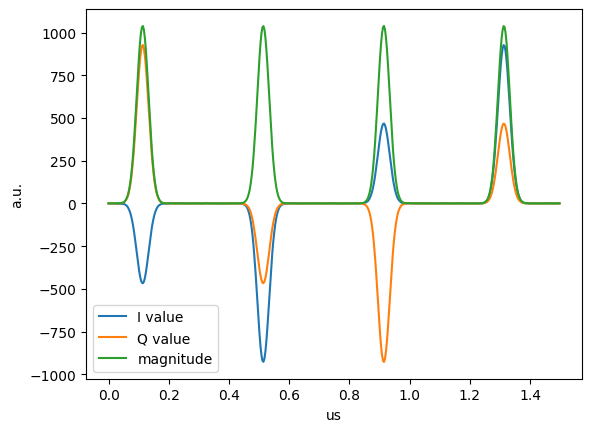

In [19]:
# vary phases of I and Q
class TestProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['freq'], gen_ch=gen_ch)

        ramp_len = 0.2
        self.add_gauss(ch=gen_ch, name="ramp", sigma=ramp_len/10, length=ramp_len, even_length=True)

        self.add_pulse(ch=gen_ch, name="gauss1", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1, 
                      )
        
        self.add_pulse(ch=gen_ch, name="gauss2", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       phase=90,
                       gain=1, 
                      )

        self.add_pulse(ch=gen_ch, name="gauss3", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       phase=180,
                       gain=1, 
                      )

        self.add_pulse(ch=gen_ch, name="gauss4", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=500, 
                       phase=270,
                       gain=1, 
                      )

    def _body(self, cfg):
            self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)
            self.pulse(ch=cfg['gen_ch'], name="gauss1", t=0)
            self.pulse(ch=cfg['gen_ch'], name="gauss2", t=0.4)
            self.pulse(ch=cfg['gen_ch'], name="gauss3", t=0.8)
            self.pulse(ch=cfg['gen_ch'], name="gauss4", t=1.2)

config = {'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': FREQ,
          'trig_time': TRIG_TIME,
          'ro_len': 1.5,
         }

prog = TestProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=10)
t = prog.get_time_axis(ro_index=0)

plt.plot(t, iq_list[0][:,0], label="I value")
plt.plot(t, iq_list[0][:,1], label="Q value")
plt.plot(t, np.abs(iq_list[0].dot([1,1j])), label="magnitude")
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us")

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 0, 'us')

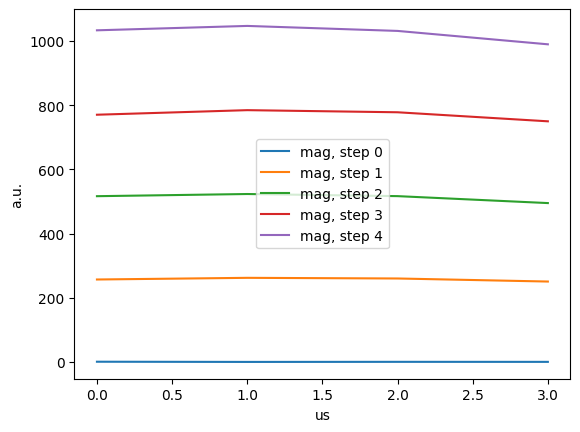

In [97]:
# make a 1D sweep program that sweeps over powers

class TestSweep(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['freq'], gen_ch=gen_ch)

        self.add_loop("myloop", self.cfg["steps"])

        self.add_gauss(ch=gen_ch, name="ramp", sigma=cfg['ramp_len']/10, length=cfg['ramp_len'], even_length=True)
        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       phase=cfg['phase'],
                       gain=cfg['gain'], 
                      )

    def _body(self, cfg):
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'] , ddr4=True)
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)

config = {'steps': 5,
          'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': FREQ,
          'trig_time': 0.51,
          'ro_len': 0.013,
          'ramp_len': 0.2,
          'phase': 0,
          'gain': QickSweep1D("myloop", 0.0, 1.0)
         }

prog = TestSweep(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=10)
t = prog.get_time_axis(ro_index=0)

for ii, iq in enumerate(iq_list[0]):
    #plt.plot(t, iq[:,0], label="I value, step %d"%(ii))
    #plt.plot(iq[:,1], label="Q value, step %d"%(ii))
    plt.plot(np.abs(iq.dot([1,1j])), label="mag, step %d"%(ii))
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us")

  0%|          | 0/5 [00:00<?, ?it/s]

[   1.27475488  257.19411443  512.15329736  774.62527231 1024.94341307]


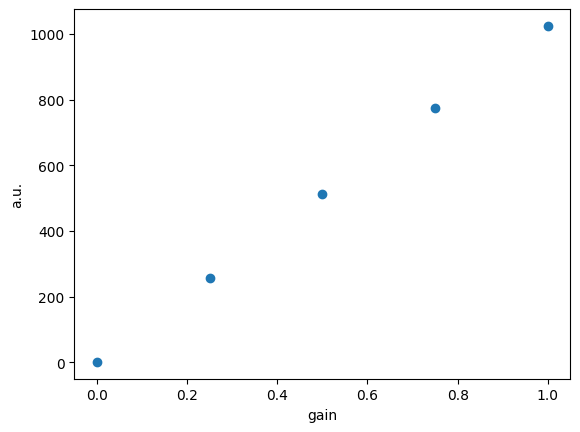

In [103]:
# same 2d seep program, but using acquire instead of acquire_decimated

class TestSweep(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['freq'], gen_ch=gen_ch)

        self.add_loop("myloop", self.cfg["steps"])

        self.add_gauss(ch=gen_ch, name="ramp", sigma=cfg['ramp_len']/10, length=cfg['ramp_len'], even_length=True)
        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       phase=cfg['phase'],
                       gain=cfg['gain'], 
                      )

    def _body(self, cfg):
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)

nsteps = 5
gmin = 0.0
gmax = 1.0

config = {'steps': nsteps,
          'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': FREQ,
          'trig_time': 0.51,
          'ro_len': 0.013,
          'ramp_len': 0.2,
          'phase': 0,
          'gain': QickSweep1D("myloop", gmin, gmax)
         }

prog = TestSweep(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire(soc)
data = np.abs(iq_list[0][0].dot([1,1j]))
plt.ylabel("a.u.")
plt.xlabel("gain")
plt.scatter(np.linspace(gmin, gmax, nsteps), data)
print(data)

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 0, 'us')

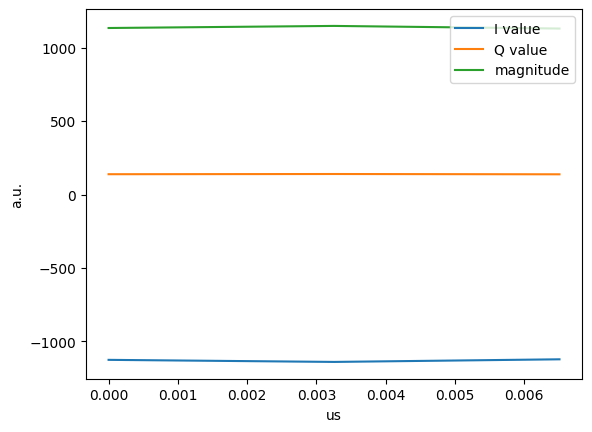

In [42]:
# testing sending pulses of different frequencies. here i am sending 300 MHz
class TestProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['freq'], gen_ch=gen_ch)

        ramp_len = 0.2
        self.add_gauss(ch=gen_ch, name="ramp", sigma=ramp_len/10, length=ramp_len, even_length=True)

        self.add_pulse(ch=gen_ch, name="gauss1", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1, 
                      )

    def _body(self, cfg):
            self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)
            self.pulse(ch=cfg['gen_ch'], name="gauss1", t=0)

config = {'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': FREQ - 200,
          'trig_time': TRIG_TIME,
          'ro_len': 0.4,
         }

prog = TestProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=10)
t = prog.get_time_axis(ro_index=0)

plt.plot(t, iq_list[0][:,0], label="I value")
plt.plot(t, iq_list[0][:,1], label="Q value")
plt.plot(t, np.abs(iq_list[0].dot([1,1j])), label="magnitude")
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us")

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 0, 'us')

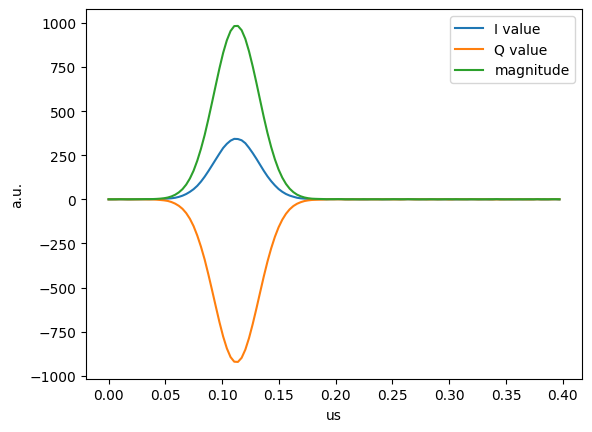

In [22]:
# testing sending pulses of different frequencies. here i am sending 700 MHz
class TestProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['freq'], gen_ch=gen_ch)

        ramp_len = 0.2
        self.add_gauss(ch=gen_ch, name="ramp", sigma=ramp_len/10, length=ramp_len, even_length=True)

        self.add_pulse(ch=gen_ch, name="gauss1", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1, 
                      )

    def _body(self, cfg):
            self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)
            self.pulse(ch=cfg['gen_ch'], name="gauss1", t=0)

config = {'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': FREQ + 200,
          'trig_time': TRIG_TIME,
          'ro_len': 0.4,
         }

prog = TestProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=10)
t = prog.get_time_axis(ro_index=0)

plt.plot(t, iq_list[0][:,0], label="I value")
plt.plot(t, iq_list[0][:,1], label="Q value")
plt.plot(t, np.abs(iq_list[0].dot([1,1j])), label="magnitude")
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us")

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 0, 'us')

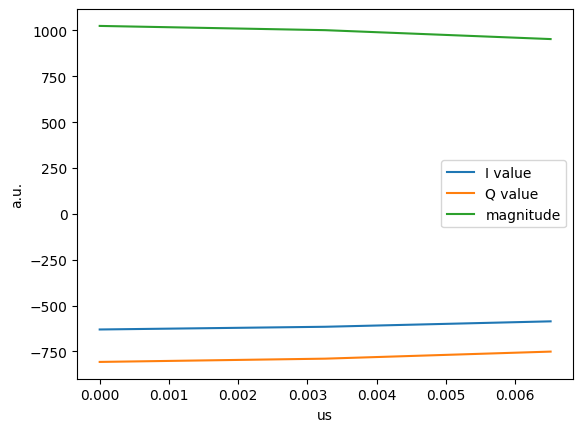

In [4]:
# finding readout window for freq scan
class FrequencySpectroscopy(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['freq'], gen_ch=gen_ch)

        ramp_len = 0.2
        self.add_gauss(ch=gen_ch, name="ramp", sigma=ramp_len/10, length=ramp_len, even_length=True)

        self.add_pulse(ch=gen_ch, name="gauss1", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1, 
                      )

    def _body(self, cfg):
            self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)
            self.pulse(ch=cfg['gen_ch'], name="gauss1", t=0)

config = {'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': FREQ,
          'trig_time': 0.5143229166666667,
          'ro_len': 0.01,
         }

prog = FrequencySpectroscopy(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=10)
t = prog.get_time_axis(ro_index=0)

plt.plot(t, iq_list[0][:,0], label="I value")
plt.plot(t, iq_list[0][:,1], label="Q value")
plt.plot(t, np.abs(iq_list[0].dot([1,1j])), label="magnitude")
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us")

  0%|          | 0/10 [00:00<?, ?it/s]

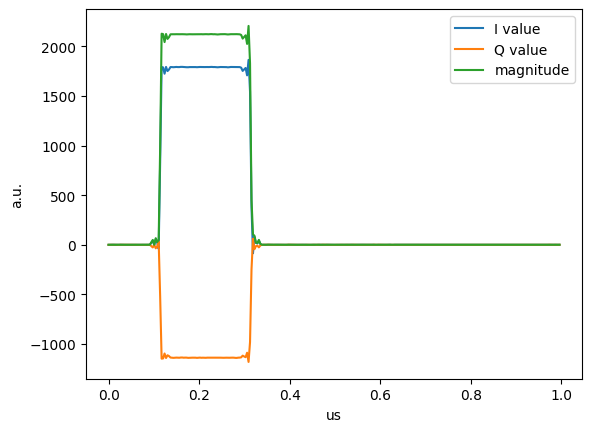

In [11]:
# random program with tProc instructions
class TestProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
        self.add_readoutconfig(ch=ro_ch, name='ro', freq=cfg['freq'], gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="myconst", ro_ch=ro_ch, 
                       style="const", 
                       length=0.2, 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0,
                      )

    def _body(self, cfg):
        self.send_readoutconfig(ch=cfg['ro_ch'], name='ro', t=0)
        self.pulse(ch=cfg['gen_ch'], name="myconst", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)

config = {'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': FREQ,
          'trig_time': TRIG_TIME - 0.1,
          'ro_len': 1,
         }

prog = TestProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=10)
t = prog.get_time_axis(ro_index=0)

plt.plot(t, iq_list[0][:,0], label="I value")
plt.plot(t, iq_list[0][:,1], label="Q value")
plt.plot(t, np.abs(iq_list[0].dot([1,1j])), label="magnitude")
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us");